In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

## Prepping Data 

In [85]:
df = pd.read_csv('../data/semi_clean_df.csv')

In [86]:
df['UNHAP42'].describe()

count    6155.000000
mean        0.427782
std         3.246724
min        -9.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        99.000000
Name: UNHAP42, dtype: float64

In [87]:
#Grabbing UNHAP42 values between 0-4
df = df.loc[(df['UNHAP42'] >= 0) & (df['UNHAP42'] <= 4), :]

In [88]:
#Making 2 classes 
df['UNHAP42'] = df['UNHAP42'].map({0:0, 1:1, 2:1, 3:1, 4:1})

In [89]:
df['UNHAP42'].value_counts(normalize=True)

0    0.736149
1    0.263851
Name: UNHAP42, dtype: float64

In [90]:
df.shape

(5920, 67)

## Splitting and SMOTE 

In [69]:
#training and testing set
X = df.drop(columns='UNHAP42')
y = df['UNHAP42']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [70]:
counter = Counter(y_train)
print(f'Training Targets:{counter}')
counter = Counter(y_test)
print(f'Testing Targets:{counter}')

Training Targets:Counter({0: 3268, 1: 1172})
Testing Targets:Counter({0: 1090, 1: 390})


In [71]:
oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

In [72]:
counter = Counter(y_train)
print(f'New Training Target: {counter}')

New Training Target: Counter({0: 3268, 1: 3268})


## Fitting Base Model 

In [73]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

AdaBoostClassifier()

In [74]:
print(f'Testing Score: {ada.score(X_test, y_test)}')
print(f'Training Score: {ada.score(X_train, y_train)}')

Testing Score: 0.8425675675675676
Training Score: 0.8861689106487148


In [75]:
print(f'Testing F1 Score: {f1_score(y_test, ada.predict(X_test))}')
print(f'Training F1 Score: {f1_score(y_train, ada.predict(X_train))}')

Testing F1 Score: 0.687248322147651
Training F1 Score: 0.8832758079698776


In [76]:
y_train

0       0
1       1
2       0
3       0
4       0
       ..
6531    1
6532    1
6533    1
6534    1
6535    1
Name: UNHAP42, Length: 6536, dtype: int64

## Scaled Model

In [77]:
X = df.drop(columns='UNHAP42')
y = df['UNHAP42']

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

#resample
oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)

In [78]:
#scale the data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [79]:
y_train.value_counts()

1    3268
0    3268
Name: UNHAP42, dtype: int64

In [80]:
y_test.value_counts()

0    1090
1     390
Name: UNHAP42, dtype: int64

In [81]:
ada = AdaBoostClassifier()
ada.fit(X_train_sc, y_train)
ada.score(X_test_sc, y_test)

0.8425675675675676

In [82]:
f1_score(y_test, ada.predict(X_test_sc))

0.687248322147651

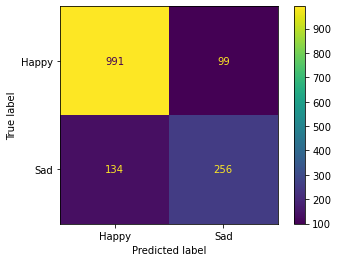

In [83]:
preds = ada.predict(X_test_sc)

accuracy = pd.DataFrame(preds)
accuracy['preds'] = preds
accuracy.columns = ['actual', 'preds']

cm = confusion_matrix(y_test, preds)
cm 

disp =  ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Happy', 'Sad'])
disp.plot();

In [84]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1090
           1       0.72      0.66      0.69       390

    accuracy                           0.84      1480
   macro avg       0.80      0.78      0.79      1480
weighted avg       0.84      0.84      0.84      1480



## Implementing Pipeline  

In [7]:
#training and testing set
X = df.drop(columns='UNHAP42')
y = df['UNHAP42']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [16]:
from numpy import mean

k_values = [1,2,3,4,5,6,7]
for k in k_values:
    model = AdaBoostClassifier()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('model', model)]
    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=1)
    score = mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k,score))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_par

> k=1, Mean ROC AUC: nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_par

> k=2, Mean ROC AUC: nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_par

> k=3, Mean ROC AUC: nan
> k=4, Mean ROC AUC: nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_par

> k=5, Mean ROC AUC: nan
> k=6, Mean ROC AUC: nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_par

> k=7, Mean ROC AUC: nan


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_par

In [19]:
pipe = Pipeline([
    ('sm', SMOTE(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42))
])

In [25]:
pipe_params = {
    'sm__k_neighbors':[3, 4, 5],
    'sm__sampling_strategy':[0.1, 0.5],
    'ada__n_estimators':[25, 50],    
}

In [26]:
ada_gs = GridSearchCV(pipe, 
                  param_grid=pipe_params
                  ,cv=5)

In [27]:
ada_gs.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_par

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('ada', AdaBoostClassifier())]),
             param_grid={'ada__n_estimators': [25, 50],
                         'sm__k_neighbors': [3, 4, 5],
                         'sm__sampling_strategy': [0.1, 0.5]})

In [59]:
ada_gs.score(X_test, y_test)

0.8358108108108108

In [60]:
ada_gs.best_estimator_

Pipeline(steps=[('sm', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('ada', AdaBoostClassifier())])